In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
tawsifurrahman_covid19_radiography_database_path = kagglehub.dataset_download('tawsifurrahman/covid19-radiography-database')

print('Data source import complete.')


Using Colab cache for faster access to the 'covid19-radiography-database' dataset.
Data source import complete.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some random chart
x = np.linspace(0, 10, 100)
y = np.sin(x)

plt.plot(x, y)
plt.title("Sample Chart")

# Save to Google Drive
plt.savefig("/content/drive/MyDrive/sample_chart.png")
plt.close()


In [4]:
#import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers

from tensorflow.keras.layers import Input,GlobalAveragePooling2D,Dense, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate , ReLU

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [5]:

def create_df(data_dir):
    image_paths = glob(os.path.join(data_dir, "*", "images", "*.png"))
    mask_paths = []

    for img_path in image_paths:
        # Replace "images" with "masks" in the path
        mask_path = img_path.replace(os.sep + "images" + os.sep, os.sep + "masks" + os.sep)
        mask_paths.append(mask_path)

    df = pd.DataFrame({
        "images_paths": image_paths,
        "masks_paths": mask_paths
    })

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df


In [6]:
def load_image(image_path, mask_path):
    # read images
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    IMG_HEIGHT  =256
    IMG_WIDTH  = 256
    # resize
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])

    # normalize to [-1, 1] (Pix2Pix requirement)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    mask = (tf.cast(mask, tf.float32) / 127.5) - 1

    return image, mask

In [7]:
def make_dataset(df, batch_size=4, shuffle=True):
    image_paths = df["images_paths"].values
    mask_paths = df["masks_paths"].values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [8]:

class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer="ones",
            trainable=True,
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
        )

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        return self.gamma * (x - mean) / tf.sqrt(var + self.epsilon) + self.beta

In [9]:

# For generator
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(InstanceNormalization())
    result.add(layers.LeakyReLU())
    return result

# For discriminator
def downsample2(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Step 1: upsample
    result.add(layers.UpSampling2D(size=(2, 2), interpolation='nearest'))
    # Step 2: conv
    result.add(layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Encoder (Downsampling)
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (128x128)
        downsample(128, 4),                        # (64x64)
        downsample(256, 4),                        # (32x32)
        downsample(512, 4),                        # (16x16)
        downsample(512, 4),                        # (8x8)
        downsample(512, 4),                        # (4x4)
        downsample(512, 4),                        # (2x2)
    ]

    # Decoder (Upsampling)
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (4x4)
        upsample(512, 4, apply_dropout=True),  # (8x8)
        upsample(512, 4, apply_dropout=True),  # (16x16)
        upsample(215, 4),                      # (32x32)
        upsample(128, 4),                      # (64x64)
        upsample(64, 4),                      # (128x128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(
        3, 4, strides=2, padding="same",
        kernel_initializer=initializer,
        activation="tanh"
    )  # (256x256x3)

    # U-Net forward pass
    x = inputs
    skips = []

    for down in down_stack:
        x = down(x)
        skips.append(x)

    bottleneck = skips[-1]
    skips = reversed(skips[:-1])

    x = bottleneck
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)


In [12]:
# create DataFrame
df = create_df(tawsifurrahman_covid19_radiography_database_path + "/COVID-19_Radiography_Dataset/")
train_df, valid_df, test_df = split_df(df)

# build datasets
train_dataset = make_dataset(train_df, batch_size=4)
valid_dataset = make_dataset(valid_df, batch_size=4)
test_dataset = make_dataset(test_df, batch_size=4)

# # create models
generator = Generator()



In [13]:
import tensorflow as tf

checkpoint_dir = "/content/drive/MyDrive/pix2pix_checkpoints/"
checkpoint = tf.train.Checkpoint(generator=generator)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()

print("✅ Generator restored and ready for prediction")


✅ Generator restored and ready for prediction


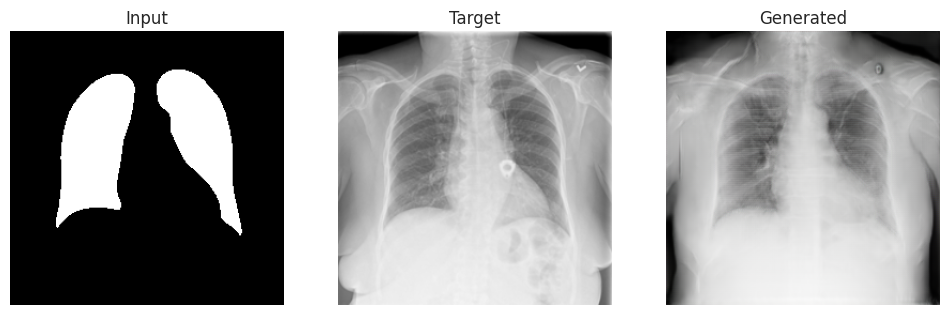

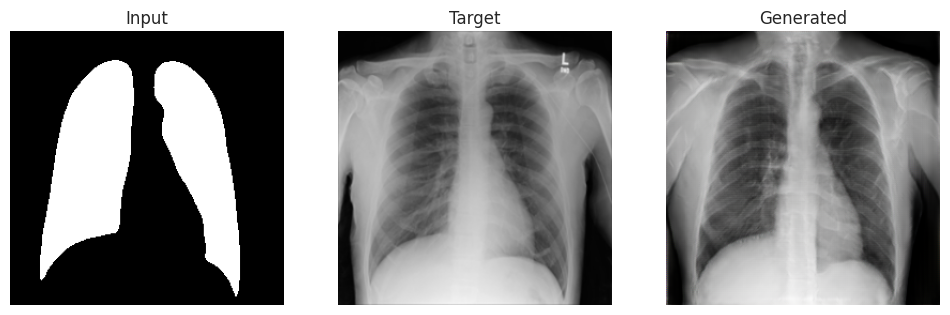

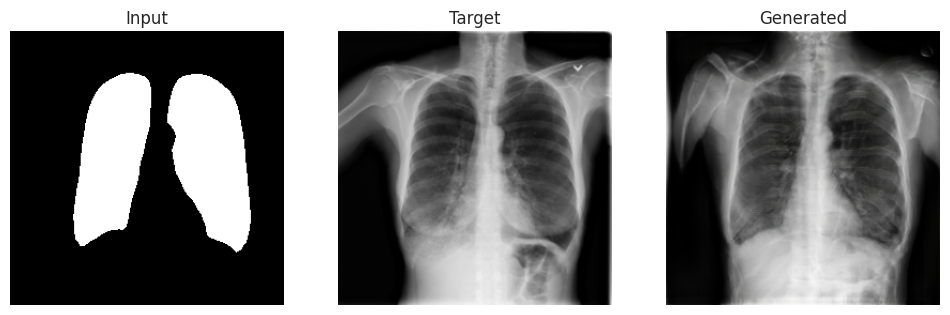

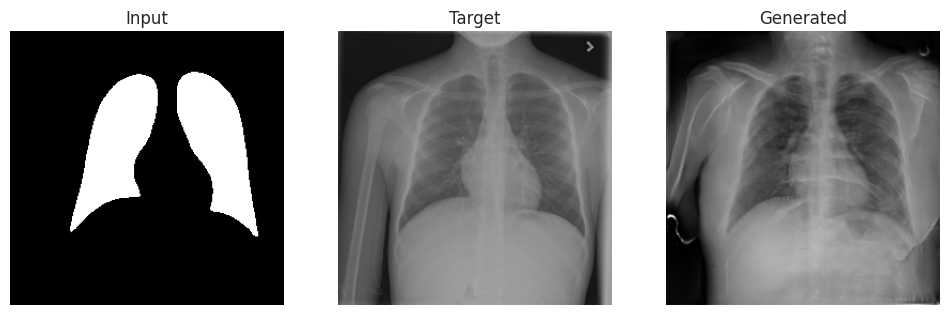

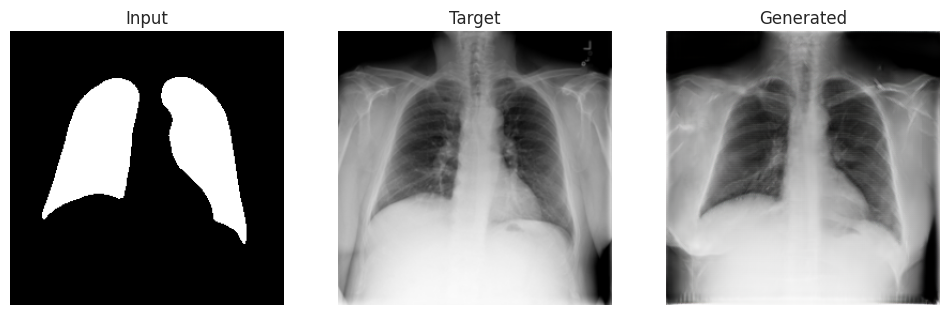

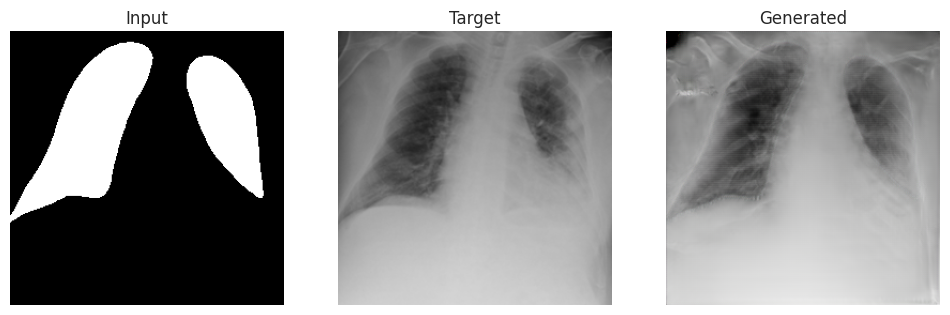

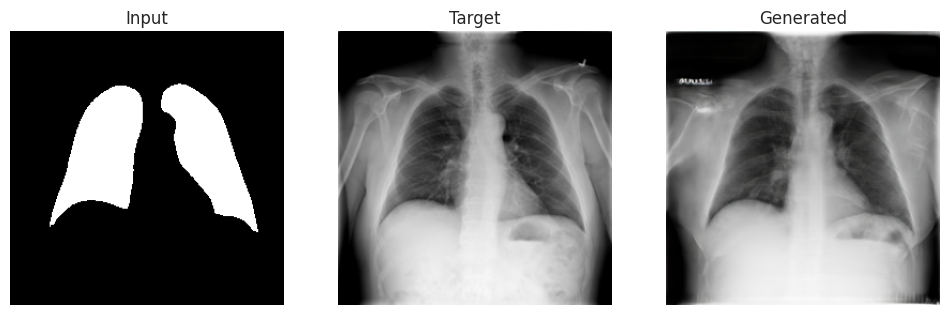

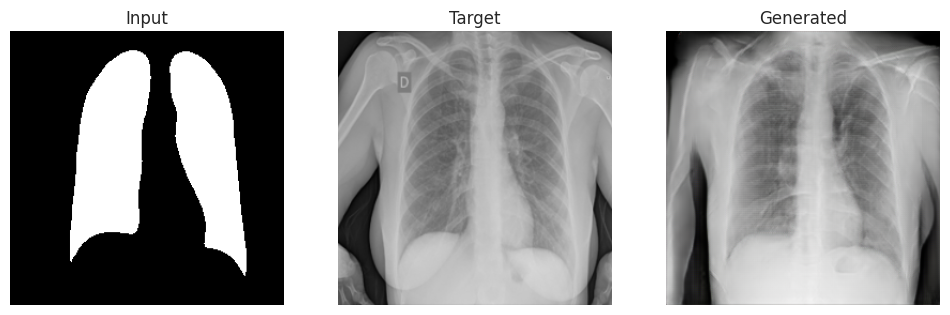

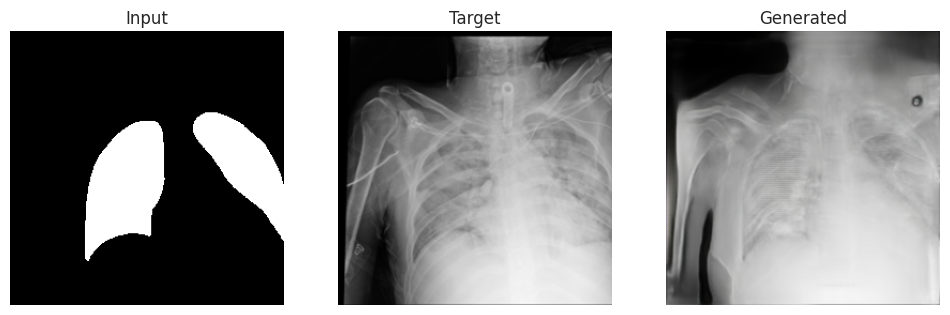

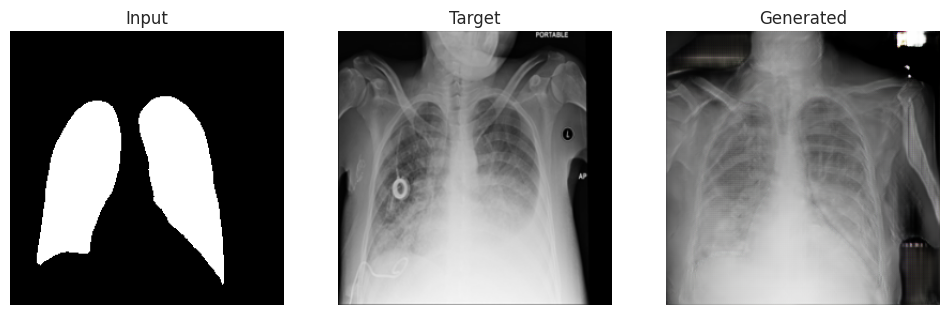

In [22]:

# Pick 10 random batches from the dataset
for n in range(10):
    sample_tar, sample_inp = next(iter(test_dataset))
    prediction = generator(sample_inp, training=False)

    plt.figure(figsize=(12, 4))
    display_list = [sample_inp[0], sample_tar[0], prediction[0]]
    title = ["Input", "Target", "Generated"]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)  # scale [-1,1] -> [0,1]
        plt.axis("off")
    plt.show()

In [15]:


def evaluate_pix2pix(generator, test_dataset):
    mae_list, mse_list, psnr_list, ssim_list = [], [], [], []

    for tar, inp in test_dataset:
        # Generate output
        pred = generator(inp, training=False)

        # Make sure values are in [-1,1], then rescale to [0,1] for metrics
        tar = (tar + 1) / 2.0
        pred = (pred + 1) / 2.0

        # Loop over batch
        for i in range(tar.shape[0]):
            t = tar[i]
            p = pred[i]

            # Compute metrics
            mae = tf.reduce_mean(tf.abs(t - p)).numpy()
            mse = tf.reduce_mean(tf.square(t - p)).numpy()
            psnr = tf.image.psnr(t, p, max_val=1.0).numpy()
            ssim = tf.image.ssim(t, p, max_val=1.0).numpy()

            mae_list.append(mae)
            mse_list.append(mse)
            psnr_list.append(psnr)
            ssim_list.append(ssim)

    # Averages
    results = {
        "MAE": np.mean(mae_list),
        "MSE": np.mean(mse_list),
        "PSNR": np.mean(psnr_list),
        "SSIM": np.mean(ssim_list)
    }

    return results



In [18]:
metrics = evaluate_pix2pix(generator, test_dataset)
print("Evaluation metrics on test set:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Evaluation metrics on test set:
MAE: 0.0794
MSE: 0.0156
PSNR: 18.8676
SSIM: 0.6614


In [19]:
metrics = evaluate_pix2pix(generator, valid_dataset)
print("Evaluation metrics on test set:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Evaluation metrics on test set:
MAE: 0.0802
MSE: 0.0157
PSNR: 18.7731
SSIM: 0.6576


In [20]:
metrics = evaluate_pix2pix(generator, train_dataset)
print("Evaluation metrics on test set:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Evaluation metrics on test set:
MAE: 0.0796
MSE: 0.0154
PSNR: 18.8406
SSIM: 0.6583
